In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from fuzzywuzzy import fuzz
from tqdm import tqdm

sns.set_style("whitegrid")

In [2]:
from tqdm.auto import tqdm
tqdm.pandas()

/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib/python3.7/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
import nltk
import nltk.stem

In [4]:
#Load the data
import pickle
with open("../data/deduped_policy_text_v11no_html_with_links_and_emails.pickle", "rb") as f:
#with open("../data/deduped_policy_text_v11.pickle", "rb") as f:
    df_deduped = pickle.load(f)

In [5]:
df = df_deduped

In [6]:
#df = df_deduped.sample(10000)

In [7]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [8]:
gdpr_phrases = []
with open("data/GDPR_phrases.txt") as f:
    for line in f.readlines():
        gdpr_phrases.append(" ".join(map(lemmatizer.lemmatize,line.strip().split(" "))))

In [9]:
def lemmatize_policy(policy_text):
    return " ".join(map(lemmatizer.lemmatize,nltk.word_tokenize(policy_text.lower())))

In [10]:
df["policy_text_lemmatized"] = df.policy_text.progress_map(lemmatize_policy)

In [11]:
print(df.policy_text_lemmatized)

237698     | | 1. this site is provided a a public servic...
1043500    femina.in is the registered domain name and of...
892937     this privacy policy governs the manner in whic...
1118180    our goal at coupon connection is to help you a...
337273     we recognize that your privacy is important . ...
                                 ...                        
1221991    privacy policy your privacy is very important ...
340360     effective date : may 23 , 2018 tough domain ll...
892528     published : june 29 , 2010 kalmbach publishing...
79317      we are committed to protecting consumer privac...
547901     | | | | privacy policy | table of content | * ...
Name: policy_text_lemmatized, Length: 910546, dtype: object


In [12]:
def count_gdpr_docs(df):
    s_ct = df.policy_text_lemmatized.apply(lambda x: phrase in x).value_counts()
    try:
        return s_ct[True]
    except KeyError:
        return 0

cols = []
for phrase in gdpr_phrases:
    s_phrase_count = df.groupby("year_season").apply(count_gdpr_docs).rename("phrase_count")
    #print(s_phrase_count)
    df_phrase_count = pd.DataFrame([s_phrase_count]).T.reset_index()
    df_phrase_count["phrase"] = phrase
    cols.append(
        df_phrase_count
    )
    
output_df = pd.concat(cols)

In [13]:
ys_counts = df.groupby("year_season").size()
output_df["phrase_perc"] = output_df.apply(lambda row: row.phrase_count / ys_counts[row.year_season], axis=1)

In [14]:
output_df

,year_season,phrase_count,phrase,phrase_perc
0,1997_A,0,controller,0.000000
1,1997_B,0,controller,0.000000
2,1998_A,0,controller,0.000000
3,1998_B,0,controller,0.000000
4,1999_A,0,controller,0.000000
...,...,...,...,...
41,2017_B,31,general data protection regulation,0.000926
42,2018_A,1394,general data protection regulation,0.052783
43,2018_B,3482,general data protection regulation,0.112610
44,2019_A,4697,general data protection regulation,0.132418


In [15]:
output_df = output_df.sort_values(["year_season"], ascending=True)

In [23]:
good_phrases = set(output_df[(output_df.phrase_perc < 0.01) & (output_df.year_season == "2016_B")].phrase)
good_phrases

{'automated decision-making',
 'contractual requirement',
 'data portability',
 'data protection officier',
 'erasure',
 'further processing',
 'gdpr',
 'general data protection regulation',
 'legal basis',
 'legitimate interest',
 'official authority',
 'performance of a contract',
 'public interest',
 'rectification',
 'statutory requirement',
 'supervisory authority',
 'third country',
 'vital interest',
 'withdraw consent'}

<AxesSubplot:xlabel='year_season', ylabel='phrase_perc'>

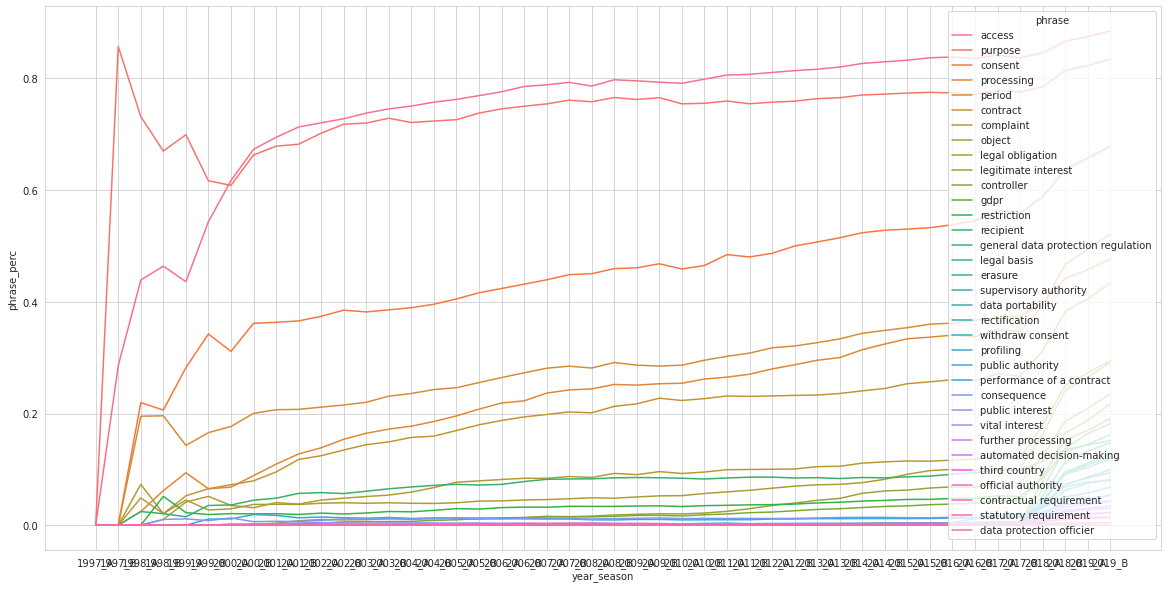

In [17]:
plt.figure(figsize=(20,10))

hue_order = output_df[output_df.year_season == "2019_B"].sort_values("phrase_perc",ascending=False).phrase

sns.lineplot(x="year_season",y="phrase_perc",hue="phrase",data=output_df,hue_order=hue_order)

<AxesSubplot:xlabel='year_season', ylabel='phrase_perc'>

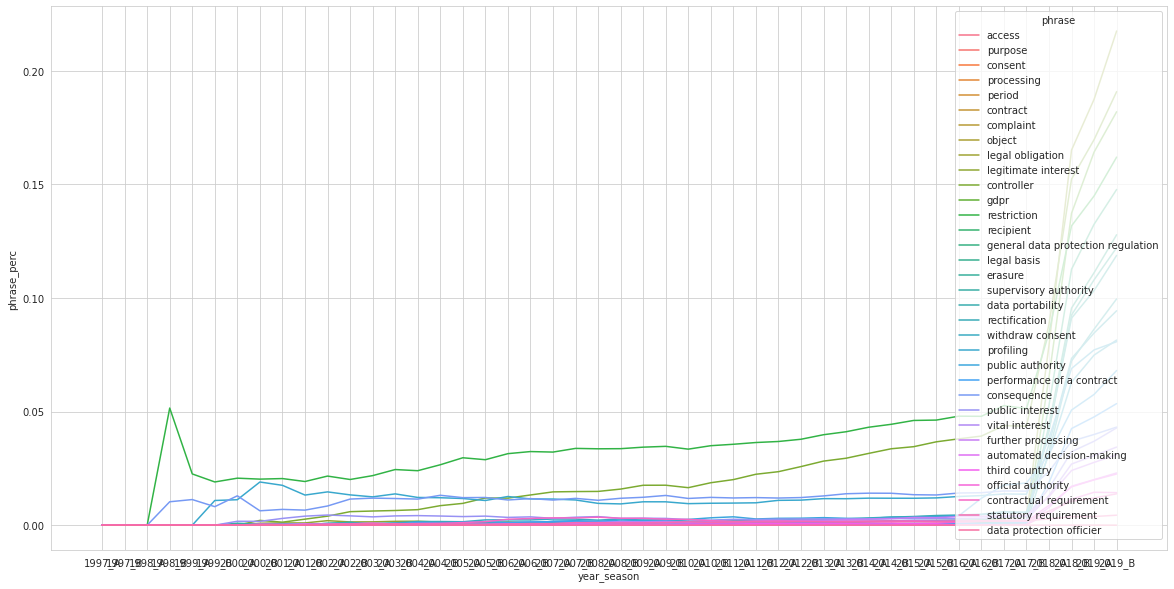

In [18]:
plt.figure(figsize=(20,10))


hue_order = output_df[output_df.year_season == "2019_B"].sort_values("phrase_perc",ascending=False).phrase

sns.lineplot(x="year_season",y="phrase_perc",hue="phrase",data=output_df[output_df.phrase.isin(good_phrases)],hue_order=hue_order)

In [19]:
list(df)

['site_url',
 'year',
 'season',
 'policy_text',
 'policy_snapshot_url',
 'policy_filetype',
 'raw_source_path',
 'link_text',
 'homepage_snapshot_url',
 'homepage_snapshot_redirected_url',
 'sha1',
 'flesch_kincaid',
 'smog',
 'flesch_ease',
 'policy_title',
 'text_len',
 'word_count',
 'year_season',
 'simhash',
 'policy_url',
 'home_domain',
 'ip_based_homepage_url',
 'categories',
 'policy_snapshot_domain',
 'strict_updated',
 'simhash_updated',
 'homepage_snapshot_domain',
 'homepage_snapshot_redirected_domain',
 'parked_domain',
 'classifier_probability',
 'alexa_rank',
 'cross_domain_homepage_redir',
 'redirected_to_similar_domain',
 'cross_domain_policy',
 'emails',
 'has_email',
 'links',
 'has_external_link',
 'policy_text_lemmatized']